In [ ]:
# motivation :
# this notebook shows the work of categorizing different customer groups of clients by using pandas and pyspark

# Problem Statement : 
# There are thousands of customers with hundred of purchase behaviors, finding the patterns and categorizing them into
# different level could help sellers to better make marketing strategies to follow on main groups of customers

# result :
# Kmeans cluster and rfm categorization (recency , frequency and monetary value) are used for comparison
# In the result of RFM cluster , itshow that tier 1 and 2 should be main target due to its frequency and monetary value

# dataset source is from https://www.kaggle.com/datasets/marian447/retail-store-sales-transactions

In [1]:
from pyspark.sql import SparkSession


spark = SparkSession.builder.getOrCreate()

sales = spark.read.csv('scanner_data.csv', header=True)

# Drop the 'Unnamed: 0' column
sales = sales.drop('Unnamed: 0')

# Display the first few rows
sales.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/20 20:39:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+---+----------+-----------+--------------+------------+-----+--------+------------+
|_c0|      Date|Customer_ID|Transaction_ID|SKU_Category|  SKU|Quantity|Sales_Amount|
+---+----------+-----------+--------------+------------+-----+--------+------------+
|  1|02/01/2016|       2547|             1|         X52|0EM7L|       1|        3.13|
|  2|02/01/2016|        822|             2|         2ML|68BRQ|       1|        5.46|
|  3|02/01/2016|       3686|             3|         0H2|CZUZX|       1|        6.35|
|  4|02/01/2016|       3719|             4|         0H2|549KK|       1|        5.59|
|  5|02/01/2016|       9200|             5|         0H2|K8EHH|       1|        6.88|
+---+----------+-----------+--------------+------------+-----+--------+------------+
only showing top 5 rows



24/06/20 20:39:07 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Date, Customer_ID, Transaction_ID, SKU_Category, SKU, Quantity, Sales_Amount
 Schema: _c0, Date, Customer_ID, Transaction_ID, SKU_Category, SKU, Quantity, Sales_Amount
Expected: _c0 but found: 
CSV file: file:///Users/mac/Desktop/resume_water_zone/scanner_data.csv


In [2]:
from pyspark.sql import functions as F

sales = sales.withColumn('Date', F.to_date(F.col('Date'), 'dd/MM/yyyy'))

In [3]:
duplicates = sales.groupBy(sales.columns)\
    .count()\
    .where(F.col('count') > 1)\
    .select(F.sum('count')).collect()[0][0]

24/06/20 20:39:08 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Date, Customer_ID, Transaction_ID, SKU_Category, SKU, Quantity, Sales_Amount
 Schema: _c0, Date, Customer_ID, Transaction_ID, SKU_Category, SKU, Quantity, Sales_Amount
Expected: _c0 but found: 
CSV file: file:///Users/mac/Desktop/resume_water_zone/scanner_data.csv


In [4]:
# find null count in each column
sales.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in sales.columns])

DataFrame[_c0: bigint, Date: bigint, Customer_ID: bigint, Transaction_ID: bigint, SKU_Category: bigint, SKU: bigint, Quantity: bigint, Sales_Amount: bigint]

In [5]:
from pyspark.sql.window import Window

# Extract month from 'Date' column
sales = sales.withColumn('bill_month', F.month('Date'))

# Define Window specification
windowSpec = Window.partitionBy('Customer_ID')

# Create 'cohort_group' column , first time of purchase
sales = sales.withColumn('cohort_group', F.min('bill_month').over(windowSpec))

# Create 'cohort_index' column , Number of months passed since the customer's first purchase
sales = sales.withColumn('cohort_index', F.col('bill_month') - F.col('cohort_group') + 1)

In [6]:
# Sort 'sales' DataFrame by 'Customer_ID' and 'bill_month'
sales = sales.orderBy('Customer_ID', 'bill_month')

# Define Window specification
windowSpec = Window.partitionBy('Customer_ID').orderBy('Date')

# Create 'diff_last_purchase' column
sales = sales.withColumn('diff_last_purchase', F.datediff('Date', F.lag('Date').over(windowSpec)))

# Fill null values in 'diff_last_purchase' with 0
sales = sales.withColumn('diff_last_purchase', F.when(F.col('diff_last_purchase').isNull(), 0).otherwise(F.col('diff_last_purchase')))

In [7]:
# get the retention rate of each month after first purchase
# Define aggregation expression
agg_expr = F.countDistinct('Customer_ID')

# Pivot 'sales' DataFrame
cohort_count = sales.groupBy('cohort_group').pivot('cohort_index').agg(agg_expr)

In [8]:
# retention rate after first purchase in each month
cohort_count.sort('cohort_group').show()

+------------+----+----+----+----+----+----+----+----+----+----+----+----+
|cohort_group|   1|   2|   3|   4|   5|   6|   7|   8|   9|  10|  11|  12|
+------------+----+----+----+----+----+----+----+----+----+----+----+----+
|           1|3396|1306|1025| 597| 266| 197| 152| 137|  90|  56|  41|  40|
|           2|2221| 478| 291| 147|  95|  68|  68|  57|  22|  18|  14|NULL|
|           3|2642| 746| 651| 600| 530| 521| 530| 512| 513| 532|NULL|NULL|
|           4|2527| 728| 633| 553| 566| 595| 566| 567| 581|NULL|NULL|NULL|
|           5|2626| 626| 559| 505| 566| 551| 521| 523|NULL|NULL|NULL|NULL|
|           6|1569| 278| 274| 280| 278| 277| 300|NULL|NULL|NULL|NULL|NULL|
|           7|1213| 172| 183| 189| 182| 201|NULL|NULL|NULL|NULL|NULL|NULL|
|           8|1060| 163| 138| 143| 126|NULL|NULL|NULL|NULL|NULL|NULL|NULL|
|           9|1625| 309| 263| 297|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|
|          10|1359| 191| 204|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|
|          11|1185| 166|N

In [9]:
# Calculate cohort_size, which is the count of unique 'Customer_ID' for each 'cohort_group' when 'cohort_index' is the smallest
windowSpec = Window.partitionBy('cohort_group')
cohort_size = sales.withColumn('min_cohort_index', F.min('cohort_index').over(windowSpec))\
                   .where(F.col('cohort_index') == F.col('min_cohort_index'))\
                   .groupBy('cohort_group')\
                   .agg(F.countDistinct('Customer_ID').alias('cohort_size'))

# Calculate cohort_count (same method as the previous response)
agg_expr = F.countDistinct('Customer_ID')
cohort_count = sales.groupBy('cohort_group').pivot('cohort_index').agg(agg_expr)

# Join cohort_count and cohort_size
cohort_data = cohort_count.join(cohort_size, on='cohort_group')

# Calculate cohort_retention by dividing 'cohort_count' by 'cohort_size' for each 'cohort_group'
for column in cohort_data.columns:
    if column != 'cohort_group' and column != 'cohort_size':
        cohort_data = cohort_data.withColumn(column, F.col(column) / F.col('cohort_size'))

# Drop 'cohort_size' column
cohort_retention = cohort_data.drop('cohort_size')

In [10]:
cohort_size.show()

24/06/20 20:39:16 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+------------+-----------+
|cohort_group|cohort_size|
+------------+-----------+
|           1|       3396|
|           2|       2221|
|           3|       2642|
|           4|       2527|
|           5|       2626|
|           6|       1569|
|           7|       1213|
|           8|       1060|
|           9|       1625|
|          10|       1359|
|          11|       1185|
|          12|       1202|
+------------+-----------+



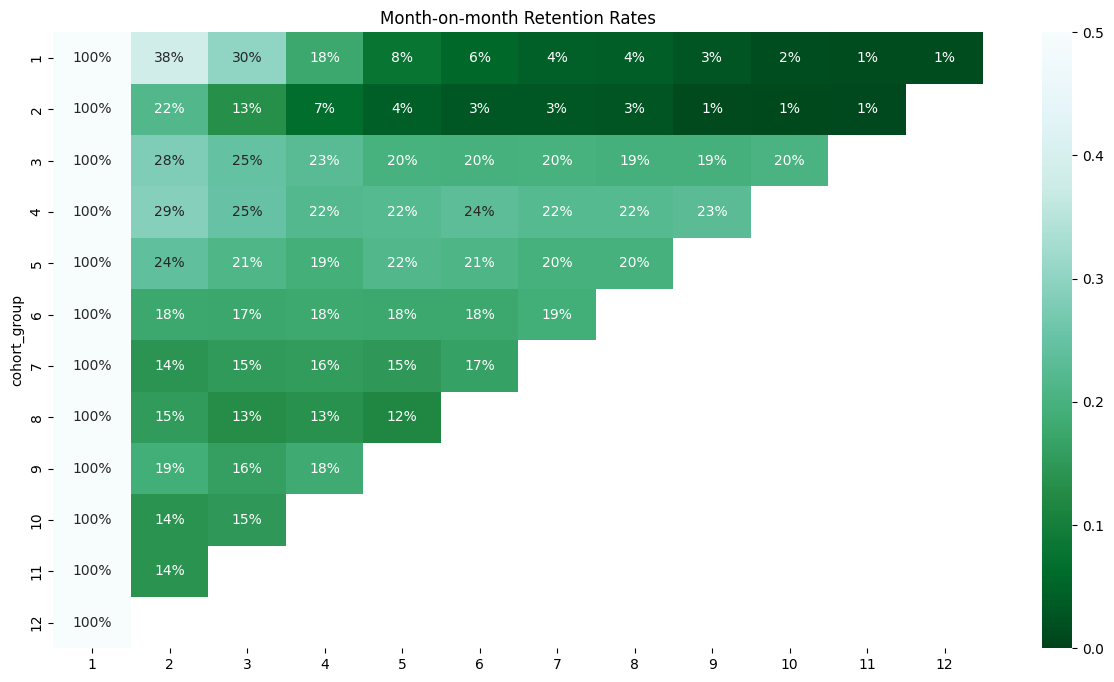

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to pandas DataFrame
cohort_retention_pd = cohort_retention.toPandas()

# Set index to 'cohort_group'
cohort_retention_pd.set_index('cohort_group', inplace=True)

# Heatmap to visualise retention rates
plt.figure(figsize=(15,8))
plt.title('Month-on-month Retention Rates')
sns.heatmap(cohort_retention_pd, annot=True, fmt='.0%', vmin=0.0, vmax=0.5, cmap="BuGn_r")
plt.show()

In [ ]:
# For each cohort (rows), this heatmap shows the percentage of active customers in each successive month. We can observe that 
# the Jan and Feb cohorts have extremely low retention rates. The retention gets better from March onwards.

In [12]:


# Define aggregation expression
agg_expr = F.mean('Sales_Amount')

# Pivot 'sales' DataFrame
cohort_avg_sales = sales.groupBy('cohort_group').pivot('cohort_index').agg(agg_expr)

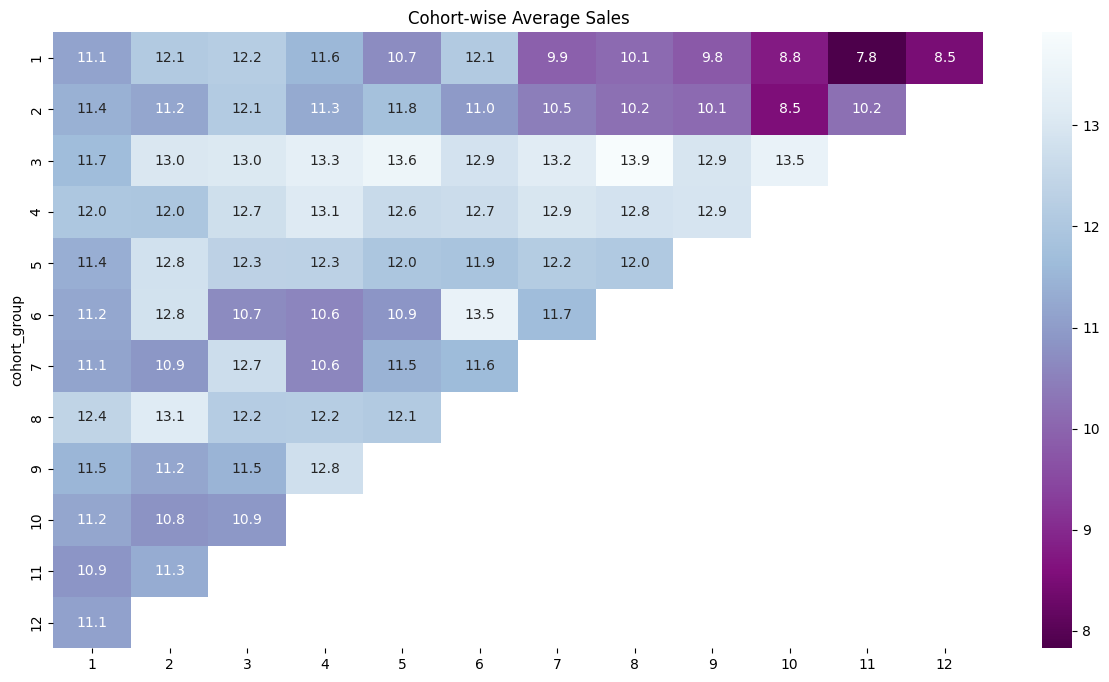

In [13]:
# Convert PySpark DataFrame to pandas DataFrame
cohort_avg_sales_pd = cohort_avg_sales.toPandas().sort_values('cohort_group')

# Set index to 'cohort_group'
cohort_avg_sales_pd.set_index('cohort_group', inplace=True)

# Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Cohort-wise Average Sales')
sns.heatmap(cohort_avg_sales_pd, annot=True, cmap="BuPu_r", fmt='.1f')
plt.show()

In [ ]:
# The Jan and Feb cohorts have shown maximum decrease in average sale value. For the other cohorts, there's not much of an impact. 
# The customers, who are retained, continue to make purchases of similar value or slightly more

In [14]:
# Calculate last_day, which is one day after the maximum date in 'sales'
last_day = sales.agg(F.max('Date')).first()[0]

agg_exprs = F.datediff(F.lit(last_day), F.max('Date'))
Date = sales.groupBy('Customer_ID').agg(agg_exprs.alias('Date'))

agg_exprs = F.count('Transaction_ID')
Transaction_ID = sales.groupBy('Customer_ID').agg(agg_exprs.alias('Transaction_ID')).withColumnRenamed( 
                   "Customer_ID","Customer_ID_1")

agg_exprs = F.sum('Sales_Amount')
Sales_Amount = sales.groupBy('Customer_ID').agg(agg_exprs.alias('Sales_Amount')).withColumnRenamed( 
                   "Customer_ID","Customer_ID_1")

In [15]:

rfm = Date.join(Transaction_ID, Date.Customer_ID == Transaction_ID.Customer_ID_1, 'inner').drop('Customer_ID_1')
rfm = rfm.join(Sales_Amount, rfm.Customer_ID == Sales_Amount.Customer_ID_1, 'inner').drop('Customer_ID_1')

# Rename columns
rfm = rfm.withColumnRenamed('Date', 'recency')\
         .withColumnRenamed('Transaction_ID', 'frequency')\
         .withColumnRenamed('Sales_Amount', 'monetary_value')

# Show the first 10 rows
rfm.show(3)

+-----------+-------+---------+--------------+
|Customer_ID|recency|frequency|monetary_value|
+-----------+-------+---------+--------------+
|       9583|    362|        2|          7.91|
|       6731|    310|        6|         43.56|
|       5325|    218|       12|        101.91|
+-----------+-------+---------+--------------+
only showing top 3 rows



In [ ]:
# We will assign low ratings/quartiles to high values of recency (beacuse higher number of days since last purchase is undesirable)
# For frequency and monetary value, higher values will be assigned higher ratings/quartiles

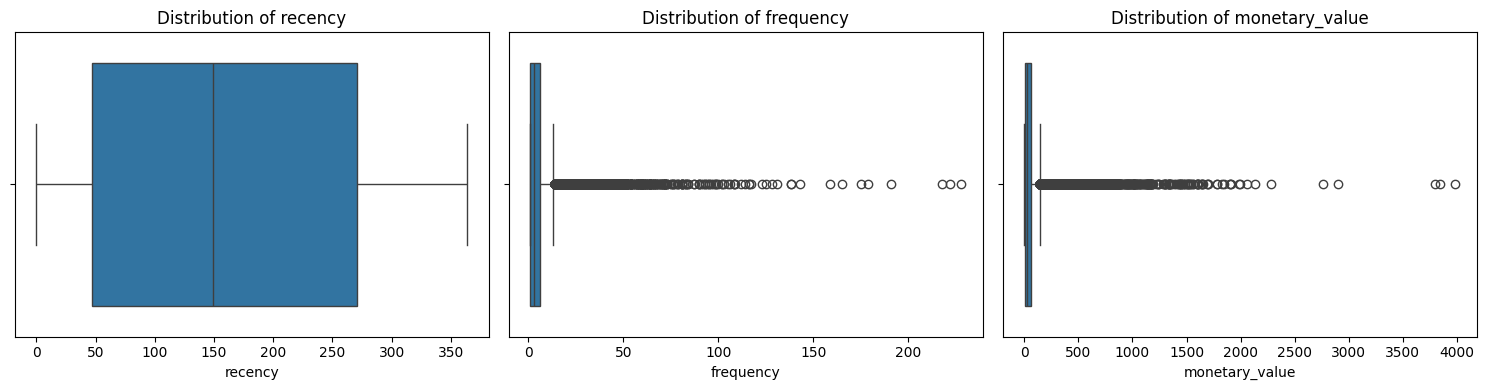

In [16]:
rfm_pd = rfm.toPandas()

plt.figure(figsize=(15,4))
i=1
for col in ['recency','frequency','monetary_value']:
    ax=plt.subplot(1,3,i)
    sns.boxplot(x=rfm_pd[col])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    i +=1
plt.tight_layout()
plt.show()

In [ ]:
# Days passed since last purchase ranges from 1 to over 350 (dataset consists of 365 days only)
# The purchase frequency of customers ranges from 1 to over 200 (although there are hardly any customers beyond 100)
# Maximum total monetary value of total purchases made by a customer is 4000 dollars but majority customers are concentrated in 0-100 range

In [17]:
from pyspark.sql import functions as F

# calculate quantiles
r_quantiles = rfm.approxQuantile('recency', [0.33, 0.67], 0)
f_quantiles = rfm.approxQuantile('frequency', [0.33, 0.67], 0)
m_quantiles = rfm.approxQuantile('monetary_value', [0.33, 0.67], 0)

# assign segments based on quantiles
rfm = rfm.withColumn('r', F.when(F.col('recency') <= r_quantiles[0], 3)
                         .when(F.col('recency') <= r_quantiles[1], 2)
                         .otherwise(1))
rfm = rfm.withColumn('f', F.when(F.col('frequency') <= f_quantiles[0], 1)
                         .when(F.col('frequency') <= f_quantiles[1], 2)
                         .otherwise(3))
rfm = rfm.withColumn('m', F.when(F.col('monetary_value') <= m_quantiles[0], 1)
                         .when(F.col('monetary_value') <= m_quantiles[1], 2)
                         .otherwise(3))

# calculate RFM segment and score
rfm = rfm.withColumn('segment', F.concat(F.col('r'), F.col('f'), F.col('m')))
rfm = rfm.withColumn('score', F.col('r') + F.col('f') + F.col('m'))

rfm.show(10)

+-----------+-------+---------+------------------+---+---+---+-------+-----+
|Customer_ID|recency|frequency|    monetary_value|  r|  f|  m|segment|score|
+-----------+-------+---------+------------------+---+---+---+-------+-----+
|       9583|    362|        2|              7.91|  1|  1|  1|    111|    3|
|       6731|    310|        6|             43.56|  1|  3|  2|    132|    6|
|       5325|    218|       12|            101.91|  2|  3|  3|    233|    8|
|       2136|    262|        6|24.770000000000003|  1|  3|  2|    132|    6|
|       1572|    110|       22|186.11999999999998|  2|  3|  3|    233|    8|
|        296|    257|        6|             74.73|  1|  3|  3|    133|    7|
|       1159|    336|        4|             41.43|  1|  2|  2|    122|    5|
|       2088|    342|        1|              10.0|  1|  1|  1|    111|    3|
|        675|    294|        3|165.01000000000002|  1|  2|  3|    123|    6|
|       7252|    336|        3|12.700000000000001|  1|  2|  1|    121|    4|

In [18]:
segment_size = rfm.groupby('segment').count()

In [20]:
# check null value
rfm.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in rfm.columns]).show()

+-----------+-------+---------+--------------+---+---+---+-------+-----+
|Customer_ID|recency|frequency|monetary_value|  r|  f|  m|segment|score|
+-----------+-------+---------+--------------+---+---+---+-------+-----+
|          0|      0|        0|             0|  0|  0|  0|      0|    0|
+-----------+-------+---------+--------------+---+---+---+-------+-----+



In [21]:
from pyspark.sql.functions import mean, count

# Calculate the summary statistics
summary = rfm.groupBy('score').agg(mean('recency').alias('r_mean'),
                                   mean('frequency').alias('f_mean'),
                                   mean('monetary_value').alias('m_mean'),
                                   count('segment').alias('customer_count'))

# Round to 1 decimal place
for col in ['r_mean', 'f_mean', 'm_mean']:
    summary = summary.withColumn(col, F.round(summary[col], 1))

summary_pd = summary.toPandas()
summary_pd.set_index('score', inplace=True)
summary_styled = summary_pd.style.format("{:.1f}")
summary_styled = summary_styled.background_gradient(subset=['customer_count'], cmap='summer')

In [22]:

# Define 'segments' function
def segments(df):
    return F.when(df['score'] > 8, 'Tier1')\
            .when(df['score'] > 6, 'Tier2')\
            .when(df['score'] > 4, 'Tier3')\
            .otherwise('Tier4')

# Apply 'segments' function to 'rfm'
rfm = rfm.withColumn('rfm_cluster', segments(rfm))

# Calculate the summary statistics
summary = rfm.groupBy('rfm_cluster').agg(F.mean('recency').alias('r_mean'),
                                         F.mean('frequency').alias('f_mean'),
                                         F.mean('monetary_value').alias('m_mean'),
                                         F.count('segment').alias('customer_count'))

# Round to 1 decimal place
for col in ['r_mean', 'f_mean', 'm_mean']:
    summary = summary.withColumn(col, F.round(summary[col], 1))

summary_pd = summary.toPandas()
summary_pd.set_index('rfm_cluster', inplace=True)
summary_styled = summary_pd.style.format("{:.1f}")
summary_styled = summary_styled.background_gradient(subset=['customer_count'], cmap='summer')

In [24]:
rfm.groupBy('rfm_cluster').count().show()

+-----------+-----+
|rfm_cluster|count|
+-----------+-----+
|      Tier2| 5216|
|      Tier1| 3093|
|      Tier4| 6873|
|      Tier3| 7443|
+-----------+-----+



/var/folders/6m/1kyq0wq56bx12x382j8hdw1h0000gq/T/ipykernel_46445/2331094214.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=rfm_log_pd[col])
/var/folders/6m/1kyq0wq56bx12x382j8hdw1h0000gq/T/ipykernel_46445/2331094214.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=rfm_log_pd[col])


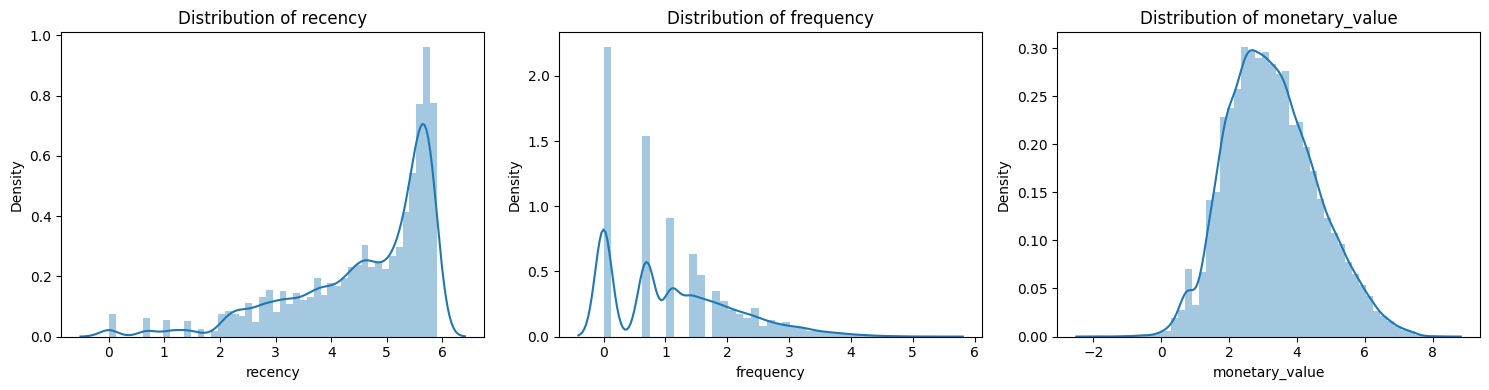

In [25]:

# Apply Log transformation
rfm_log = rfm.select('Customer_ID','recency', 'frequency', 'monetary_value','rfm_cluster').withColumn("recency", F.log("recency")).withColumn("frequency", F.log("frequency")).withColumn("monetary_value", F.log("monetary_value"))

rfm_log = rfm_log.dropna()
# Convert to Pandas for plotting
rfm_log_pd = rfm_log.toPandas()

# Round to 3 decimal places
rfm_log_pd = rfm_log_pd.round(3)

plt.figure(figsize=(15,4))
i=1
for col in ['recency','frequency','monetary_value']:
    ax=plt.histplot(1,3,i)
    sns.distplot(x=rfm_log_pd[col])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    i +=1
plt.tight_layout()
plt.show()

In [26]:
rfm_log.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in rfm_log.columns]).show()

+-----------+-------+---------+--------------+-----------+
|Customer_ID|recency|frequency|monetary_value|rfm_cluster|
+-----------+-------+---------+--------------+-----------+
|          0|      0|        0|             0|          0|
+-----------+-------+---------+--------------+-----------+



In [27]:
# machine learning is by pandas 

In [30]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
rfm_log = rfm_log_pd
rfm_log = rfm_log.set_index('Customer_ID')

#seperate tier column
rfm_cluster = rfm_log['rfm_cluster']
rfm_log = rfm_log.drop('rfm_cluster', axis=1)
scaler = StandardScaler()
scaler.fit(rfm_log)
#Data for clustering
rfm_norm= scaler.transform(rfm_log)
rfm_norm = pd.DataFrame(data=rfm_norm, index=rfm_log.index, columns=rfm_log.columns)
rfm_norm.head()

,recency,frequency,monetary_value
Customer_ID,,,
9583,1.034455,-0.447561,-0.912213
6731,0.911154,0.644471,0.377712
5325,0.630345,1.333078,1.020407
2136,0.776716,0.644471,-0.048734
1572,0.086228,1.935236,1.475586


In [33]:
# # pyspark version
# from pyspark.ml.feature import StandardScaler, VectorAssembler

# # Convert to Vector for StandardScaler
# assembler = VectorAssembler(inputCols=['recency','frequency','monetary_value'], outputCol="features")
# rfm_log = assembler.transform(rfm_log)

# # Initialize the `standardScaler`
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# rfm_log = rfm_log.dropna(how="any")
# # Fit the DataFrame to the scaler
# scale = scaler.fit(rfm_log)

# # Transform the data in `df` with the scaler
# rfm_norm = scale.transform(rfm_log)

# # Convert 'scaledFeatures' back to original columns
# rfm_norm = rfm_norm.select([F.col("scaledFeatures")[i].alias('recency') for i in range(3)])

# rfm_norm.show(5)

/var/folders/6m/1kyq0wq56bx12x382j8hdw1h0000gq/T/ipykernel_46445/3267434400.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=rfm_norm[col])
/var/folders/6m/1kyq0wq56bx12x382j8hdw1h0000gq/T/ipykernel_46445/3267434400.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=rfm_norm[col])
/var/f

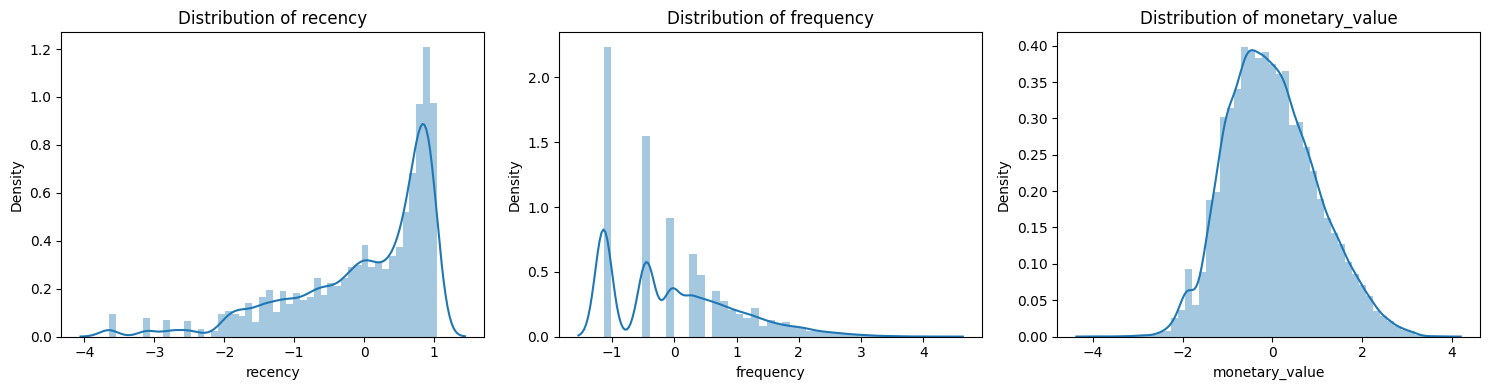

In [34]:
import numpy as np

plt.figure(figsize=(15,4))
i=1
for col in ['recency','frequency','monetary_value']:
    ax=plt.subplot(1,3,i)
    sns.histplot(x=rfm_norm[col])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    i +=1
plt.tight_layout()
plt.show();

In [35]:
# pyspark version
# # Apply Log transformation
# rfm_log = rfm.select('recency', 'frequency', 'monetary_value').withColumn("recency", F.log("recency")).withColumn("frequency", F.log("frequency")).withColumn("monetary_value", F.log("monetary_value"))

# # Convert to Pandas for plotting
# rfm_log_pd = rfm_log.toPandas()

# # Round to 3 decimal places
# rfm_log_pd = rfm_log_pd.round(3)

# plt.figure(figsize=(15,4))
# i=1
# for col in ['recency','frequency','monetary_value']:
#     ax=plt.subplot(1,3,i)
#     sns.histplot(x=rfm_log_pd[col])
#     plt.title(f'Distribution of {col}')
#     plt.xlabel(col)
#     i +=1
# plt.tight_layout()
# plt.show()

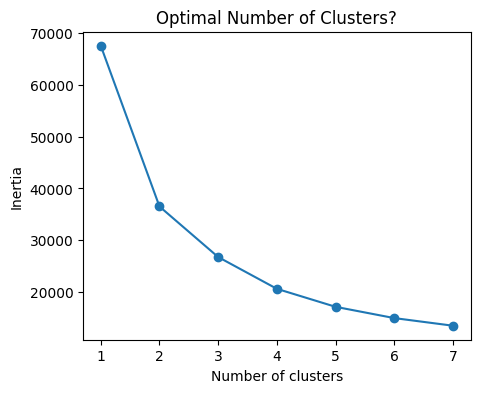

In [36]:
from sklearn.cluster import KMeans

n_clusters = range(1,8)
inertia=[]
for n in n_clusters :
    clusters = KMeans(n_clusters=n,random_state=1)
    clusters.fit(rfm_norm)
    inertia.append(clusters.inertia_)

# Plot n_clusters vs inertia
f, ax = plt.subplots(figsize=(5,4))
plt.plot(n_clusters, inertia, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(n_clusters)
plt.title('Optimal Number of Clusters?')
plt.show()

In [ ]:
# choose the start point of slope getting flat

In [37]:
# pyspark version
# from pyspark.ml.clustering import KMeans
# from pyspark.ml.evaluation import ClusteringEvaluator

# # Convert rfm_norm to vector for KMeans
# vecAssembler = VectorAssembler(inputCols=["recency", "frequency", "monetary_value"], outputCol="features")
# rfm_norm = vecAssembler.transform(rfm_norm)

# n_clusters = range(1,8)
# inertia = []
# for n in n_clusters:
#     # Trains a k-means model.
#     kmeans = KMeans().setK(n).setSeed(1).setFeaturesCol("features")
#     model = kmeans.fit(rfm_norm.select('features'))

#     # Evaluate clustering by computing Within Set Sum of Squared Errors.
#     wssse = model.computeCost(rfm_norm)
#     inertia.append(wssse)

# # Plot n_clusters vs inertia
# f, ax = plt.subplots(figsize=(5,4))
# plt.plot(n_clusters, inertia, '-o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Inertia')
# plt.xticks(n_clusters)
# plt.title('Optimal Number of Clusters?')
# plt.show()

In [38]:

# KMeans
cl = KMeans(n_clusters= 3, random_state=1)
cl.fit(rfm_norm)

cluster_labels = cl.labels_

#average metrics and size for each cluster:
rfm_k3 = rfm_norm.assign(k_cluster = cluster_labels)

#Calculate average RFM values and sizes for each cluster:
rfm_k3.groupby('k_cluster').agg({'recency': 'mean','frequency': 'mean',
                                         'monetary_value': ['mean', 'count'],}).round(0)

recency frequency monetary_value       
             mean      mean           mean  count
k_cluster                                        
0             0.0      -1.0           -1.0  10967
1             0.0       1.0            1.0   7622
2            -2.0       1.0            1.0   3935

In [39]:
# pyspark version
# from pyspark.ml.clustering import KMeans
# from pyspark.ml.feature import VectorAssembler

# # Convert rfm_norm to vector for KMeans
# vecAssembler = VectorAssembler(inputCols=["recency", "frequency", "monetary_value"], outputCol="features")
# rfm_norm = vecAssembler.transform(rfm_norm)

# # Trains a k-means model.
# kmeans = KMeans().setK(3).setSeed(1)
# model = kmeans.fit(rfm_norm.select('features'))

# # Make predictions (assign clusters)
# predictions = model.transform(rfm_norm)

# # Convert 'prediction' column back to original DataFrame
# rfm_k3 = rfm.withColumn('k_cluster', predictions['prediction'])

# # Calculate average RFM values and sizes for each cluster
# rfm_k3.groupby('k_cluster').agg(F.mean('recency').alias('recency'), 
#                                  F.mean('frequency').alias('frequency'), 
#                                  F.mean('monetary_value').alias('monetary_value_mean'),
#                                  F.count('monetary_value').alias('monetary_value_count'))\
#                                  .show()

In [40]:
rfm_norm = rfm_norm.join(rfm_cluster, 'Customer_ID')
rfm_norm

,recency,frequency,monetary_value,rfm_cluster
Customer_ID,,,,
9583,1.034455,-0.447561,-0.912213,Tier4
6731,0.911154,0.644471,0.377712,Tier3
5325,0.630345,1.333078,1.020407,Tier2
2136,0.776716,0.644471,-0.048734,Tier3
1572,0.086228,1.935236,1.475586,Tier2
...,...,...,...,...
22311,-1.193719,-0.447561,-0.396545,Tier3
20774,-1.310657,-1.136168,-1.532980,Tier3
14145,-2.778340,-0.044135,0.487349,Tier2


In [41]:

rfm_norm['k_cluster'] = cl.labels_

#Melt the data into a long format
rfm_melt = pd.melt(rfm_norm.reset_index(),id_vars=['Customer_ID','rfm_cluster','k_cluster'],value_vars=['recency', 'frequency', 'monetary_value'],
var_name='metric',value_name='value')
rfm_melt.head()

,Customer_ID,rfm_cluster,k_cluster,metric,value
0,9583,Tier4,0,recency,1.034455
1,6731,Tier3,1,recency,0.911154
2,5325,Tier2,1,recency,0.630345
3,2136,Tier3,1,recency,0.776716
4,1572,Tier2,1,recency,0.086228


In [42]:
# pyspark version
# # Add 'k_cluster' and 'rfm_cluster' to rfm_norm
# rfm_norm = rfm_norm.withColumn('k_cluster', predictions['prediction'])
# rfm_norm = rfm_norm.withColumn('rfm_cluster', rfm['rfm_cluster'])

# # Melt the data into a long format
# rfm_melt = rfm_norm.selectExpr('Customer_ID', 
#                                 'rfm_cluster', 
#                                 'k_cluster', 
#                                 'stack(3, "recency", recency, "frequency", frequency, "monetary_value", monetary_value) as (metric,value)')

# rfm_melt.show(5)

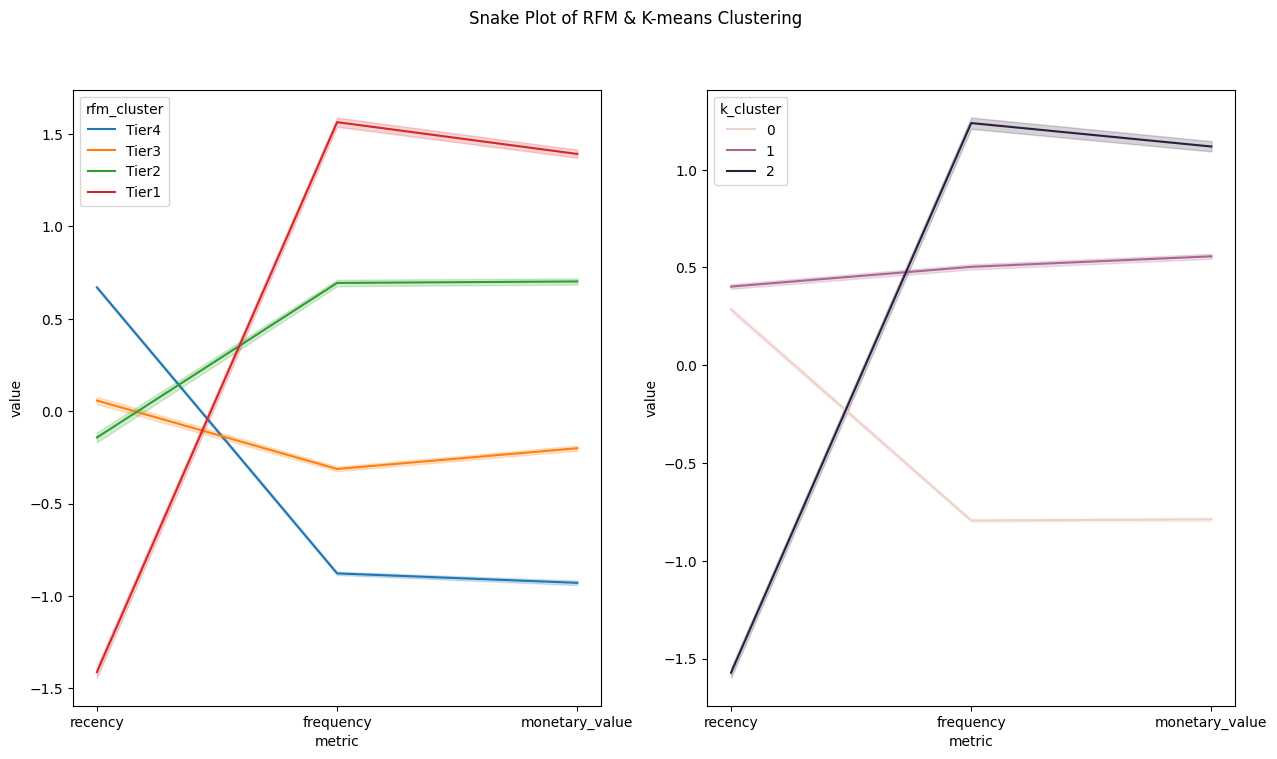

In [43]:

f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 8))
sns.lineplot(x = 'metric', y = 'value', hue = 'rfm_cluster', data = rfm_melt,ax=ax1)
sns.lineplot(x = 'metric', y = 'value', hue = 'k_cluster', data = rfm_melt,ax=ax2)

plt.suptitle("Snake Plot of RFM & K-means Clustering")
plt.show()

In [ ]:
#both of methods show hierachy level , however rfm cluster shows more obvious clustering

In [44]:
# pyspark version
# # Convert to Pandas for plotting
# rfm_melt_pd = rfm_melt.toPandas()

# f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 8))
# sns.lineplot(x = 'metric', y = 'value', hue = 'rfm_cluster', data = rfm_melt_pd,ax=ax1)
# sns.lineplot(x = 'metric', y = 'value', hue = 'k_cluster', data = rfm_melt_pd,ax=ax2)

# plt.suptitle("Snake Plot of RFM & K-means Clustering")
# plt.show()

In [45]:
rfm = rfm.toPandas()

In [46]:

k_cluster_avg = rfm_k3.groupby('k_cluster')[['recency','frequency','monetary_value']].mean()
population_avg = rfm.loc[:,['recency','frequency','monetary_value']].mean()
kmeans_imp = k_cluster_avg/population_avg -1
kmeans_imp.round(2)

,recency,frequency,monetary_value
k_cluster,,,
0,-1.00,-1.14,-1.01
1,-1.00,-0.91,-0.99
2,-1.01,-0.79,-0.98


In [47]:
# pyspark version
# # Calculate the average of 'recency', 'frequency', and 'monetary_value' for each 'k_cluster'
# k_cluster_avg = rfm_k3.groupBy('k_cluster').agg(mean(col('recency')), mean(col('frequency')), mean(col('monetary_value')))

# # Calculate the population average of 'recency', 'frequency', and 'monetary_value'
# population_avg = rfm.agg(mean(col('recency')), mean(col('frequency')), mean(col('monetary_value')))

# # Calculate the importance of each 'k_cluster' as the ratio of the 'k_cluster' average to the population average minus 1
# kmeans_imp = k_cluster_avg.join(population_avg)

# # Calculate the importance for each metric
# kmeans_imp = kmeans_imp.withColumn('recency_imp', col('avg(recency)_k') / col('avg(recency)_pop') - 1) \
#                        .withColumn('frequency_imp', col('avg(frequency)_k') / col('avg(frequency)_pop') - 1) \
#                        .withColumn('monetary_value_imp', col('avg(monetary_value)_k') / col('avg(monetary_value)_pop') - 1)

# # Round the importance to 2 decimal places
# kmeans_imp = kmeans_imp.select(col('k_cluster'), 
#                                round(col('recency_imp'), 2).alias('recency_imp'), 
#                                round(col('frequency_imp'), 2).alias('frequency_imp'), 
#                                round(col('monetary_value_imp'), 2).alias('monetary_value_imp'))

In [48]:

rfm_cluster_avg = rfm.groupby('rfm_cluster')[['recency','frequency','monetary_value']].mean()
population_avg = rfm.loc[:,['recency','frequency','monetary_value']].mean()
rfm_imp = rfm_cluster_avg/population_avg -1
rfm_imp.round(2)

,recency,frequency,monetary_value
rfm_cluster,,,
Tier1,-0.85,2.44,2.69
Tier2,-0.17,0.33,0.39
Tier3,-0.02,-0.54,-0.60
Tier4,0.53,-0.76,-0.86


In [49]:
# pyspark version

# # Calculate the average of 'recency', 'frequency', and 'monetary_value' for each 'rfm_cluster'
# rfm_cluster_avg = rfm.groupBy('rfm_cluster').agg(mean(col('recency')), mean(col('frequency')), mean(col('monetary_value')))

# # Calculate the population average of 'recency', 'frequency', and 'monetary_value'
# population_avg = rfm.agg(mean(col('recency')), mean(col('frequency')), mean(col('monetary_value')))

# # Calculate the importance of each 'rfm_cluster' as the ratio of the 'rfm_cluster' average to the population average minus 1
# rfm_imp = rfm_cluster_avg.join(population_avg)

# # Calculate the importance for each metric
# rfm_imp = rfm_imp.withColumn('recency_imp', col('avg(recency)_rfm') / col('avg(recency)_pop') - 1) \
#                        .withColumn('frequency_imp', col('avg(frequency)_rfm') / col('avg(frequency)_pop') - 1) \
#                        .withColumn('monetary_value_imp', col('avg(monetary_value)_rfm') / col('avg(monetary_value)_pop') - 1)

# # Round the importance to 2 decimal places
# rfm_imp = rfm_imp.select(col('rfm_cluster'), 
#                                round(col('recency_imp'), 2).alias('recency_imp'), 
#                                round(col('frequency_imp'), 2).alias('frequency_imp'), 
#                                round(col('monetary_value_imp'), 2).alias('monetary_value_imp'))

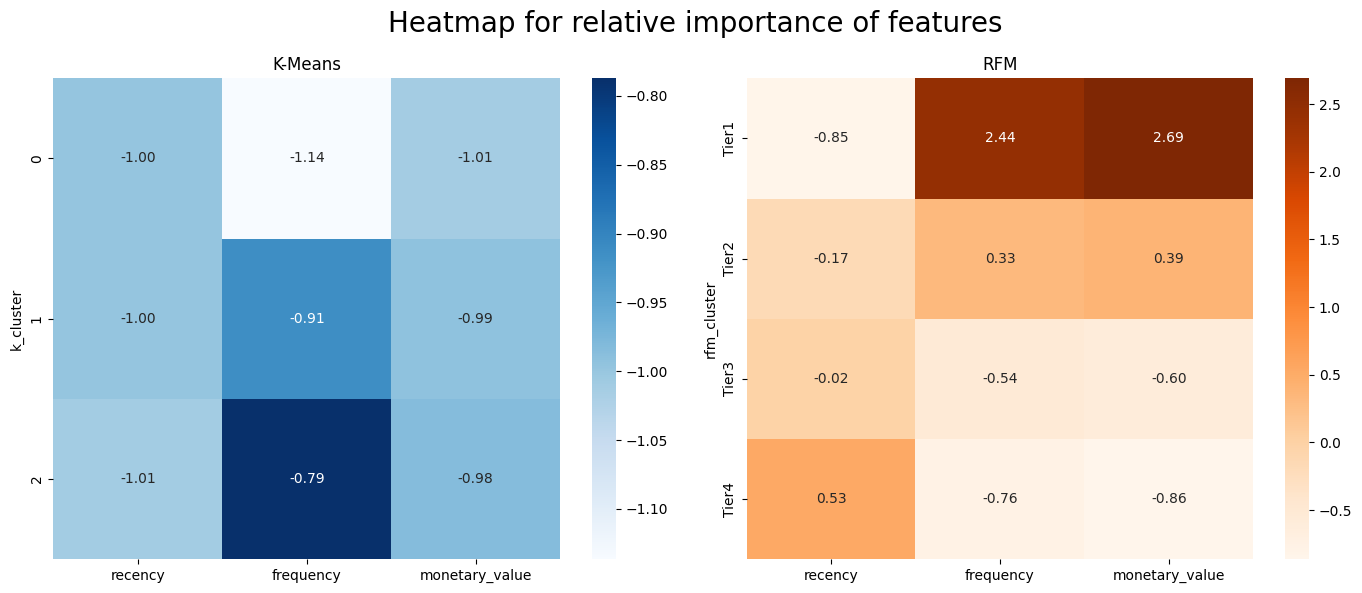

In [50]:
# heatmap with RFM
f, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 6))
sns.heatmap(data=kmeans_imp, annot=True, fmt='.2f', cmap='Blues',ax=ax1)
ax1.set(title = "K-Means")

# a snake plot with K-Means
sns.heatmap(rfm_imp, fmt= '.2f', annot = True,cmap= 'Oranges', ax=ax2)
ax2.set(title = "RFM")

plt.suptitle("Heatmap for relative importance of features",fontsize=20) #make title fontsize subtitle 

plt.tight_layout()
plt.show()

In [ ]:
# from heatmap, RFM cluster show that tier 1 and 2 should be main target due to its frequency and monetary value
# in the other hand , k-means cluster show obvious differnce only in frequency

In [51]:
# pyspark version
# # Convert to Pandas for plotting
# kmeans_imp_pd = kmeans_imp.toPandas()
# rfm_imp_pd = rfm_imp.toPandas()

# f, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 6))
# sns.heatmap(data=kmeans_imp_pd, annot=True, fmt='.2f', cmap='Blues',ax=ax1)
# ax1.set(title = "K-Means")

# sns.heatmap(data=rfm_imp_pd, fmt= '.2f', annot = True, cmap= 'Oranges', ax=ax2)
# ax2.set(title = "RFM")

# plt.suptitle("Heatmap for relative importance of features", fontsize=20)
# plt.tight_layout()
# plt.show()